In [ ]:
!pip install wordcloud matplotlib
!pip install textblob

In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
from google.cloud import storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from textblob import TextBlob

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#Data Preprocessing

In [11]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/ba780-freyajiang-db0532ba95ba.json"
client = storage.Client()
bucket = client.get_bucket('820_group_project')

In [12]:
combined_df = pd.DataFrame()

In [13]:
folders = ['London', 'Tokyo', 'New York']

In [14]:
for folder in folders:
    blobs = bucket.list_blobs(prefix=f'{folder}/')
    for blob in blobs:
        if blob.name.endswith('.csv'):
            blob_url = f"gs://{bucket.name}/{blob.name}"

            try:
                df = pd.read_csv(f'gs://{bucket.name}/{blob.name}', encoding='utf-8')
            except UnicodeDecodeError:
                try:
                    df = pd.read_csv(f'gs://{bucket.name}/{blob.name}', encoding='ISO-8859-1')
                except UnicodeDecodeError:
                    df = pd.read_csv(f'gs://{bucket.name}/{blob.name}', encoding='cp1252')

            #Append the dataframe to the combined dataframe
            combined_df = pd.concat([combined_df, df], ignore_index=True)

In [15]:
combined_df

,Personal profile,Review,Number of likes,Store name,Region
0,"Local Guide Â· 490 reviews Â· 1,667 photos",The store is small and narrow making it diffic...,NaN,Foot Locker,London
1,1 review,"William was very accommodating, made the visit...",NaN,Foot Locker,London
2,1 review,lovely experience with certain workers such as...,NaN,Foot Locker,London
3,2 reviews,My recent shopping experience at your store wa...,NaN,Foot Locker,London
4,Local Guide Â· 25 reviews Â· 52 photos,Hameema very helpful with my Air Jordan 1 for ...,NaN,Foot Locker,London
...,...,...,...,...,...
13590,60 reviews ¡¤ 34 photos,Museum 911 ? observing the historical evidence...,NaN,West NYC,New York
13591,Local Guide ¡¤ 121 reviews ¡¤ 296 photos,I found neither the choice nor the convenience...,1.0,West NYC,New York
13592,Local Guide ¡¤ 95 reviews ¡¤ 554 photos,"It no longer exists, it's a new shoe brand lik...",1.0,West NYC,New York
13593,Local Guide ¡¤ 115 reviews ¡¤ 22 photos,Perfect,1.0,West NYC,New York


In [16]:
combined_df['Review'].dropna()

0        The store is small and narrow making it diffic...
1        William was very accommodating, made the visit...
2        lovely experience with certain workers such as...
3        My recent shopping experience at your store wa...
4        Hameema very helpful with my Air Jordan 1 for ...
                               ...                        
13590    Museum 911 ? observing the historical evidence...
13591    I found neither the choice nor the convenience...
13592    It no longer exists, it's a new shoe brand lik...
13593                                              Perfect
13594                                  Variety of sneakers
Name: Review, Length: 13274, dtype: object

In [17]:
combined_df['Personal profile'] = combined_df['Personal profile'].str.replace('Â·', '|', regex=False)
combined_df['Personal profile'] = combined_df['Personal profile'].str.replace('¡¤', '|', regex=False)

In [20]:
def extract_info(profile):
    #Ensure the personal profile is string variable
    profile = str(profile)
    local_guide = 1 if 'Local Guide' in profile else 0
    reviews_match = re.search(r'(\d+)\s+reviews', profile)
    photos_match = re.search(r'(\d+)\s+photos', profile)
    number_review = int(reviews_match.group(1)) if reviews_match else 0
    number_photos = int(photos_match.group(1)) if photos_match else 0
    return local_guide, number_review, number_photos

In [21]:
combined_df[['local_guide', 'number_review', 'number_photos']] = combined_df.apply(lambda x: extract_info(x['Personal profile']), axis=1, result_type='expand')

In [22]:
combined_df.head()

,Personal profile,Review,Number of likes,Store name,Region,local_guide,number_review,number_photos
0,"Local Guide | 490 reviews | 1,667 photos",The store is small and narrow making it diffic...,NaN,Foot Locker,London,1,490,667
1,1 review,"William was very accommodating, made the visit...",NaN,Foot Locker,London,0,0,0
2,1 review,lovely experience with certain workers such as...,NaN,Foot Locker,London,0,0,0
3,2 reviews,My recent shopping experience at your store wa...,NaN,Foot Locker,London,0,2,0
4,Local Guide | 25 reviews | 52 photos,Hameema very helpful with my Air Jordan 1 for ...,NaN,Foot Locker,London,1,25,52


In [23]:
columns_to_replace_nan = ['Number of likes', 'Region', 'local_guide', 'number_review', 'number_photos']
combined_df[columns_to_replace_nan] = combined_df[columns_to_replace_nan].fillna(0)

In [24]:
combined_df['Review'] = combined_df['Review'].str.replace('Â·', '|', regex=False)
combined_df['Review'] = combined_df['Review'].str.replace('¡¤', '|', regex=False)

In [25]:
def clean_text(text):
    #Convert text to lowercase
    text = text.lower()
    #Remove punctuation and special characters
    text = re.sub(r'\W', ' ', text)
    #Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word not in stop_words]
    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
    #Join the words back into one string
    text = ' '.join(lemmatized_text)
    return text

In [26]:
combined_df['Cleaned Review'] = combined_df['Review'].apply(lambda x: clean_text(str(x)))

In [ ]:
combined_df

,Personal profile,Review,Number of likes,Store name,Region,local_guide,number_review,number_photos,Cleaned Review
0,"Local Guide | 490 reviews | 1,667 photos",The store is small and narrow making it diffic...,0,Foot Locker,London,1,490,667,store small narrow making difficult get past s...
1,1 review,"William was very accommodating, made the visit...",0,Foot Locker,London,0,0,0,william accommodating made visit easy happy he...
2,1 review,lovely experience with certain workers such as...,0,Foot Locker,London,0,0,0,lovely experience certain worker ahmed helped ...
3,2 reviews,My recent shopping experience at your store wa...,0,Foot Locker,London,0,2,0,recent shopping experience store unfortunately...
4,Local Guide | 25 reviews | 52 photos,Hameema very helpful with my Air Jordan 1 for ...,0,Foot Locker,London,1,25,52,hameema helpful air jordan 1 brother birthday ...
...,...,...,...,...,...,...,...,...,...
13590,60 reviews | 34 photos,Museum 911 ? observing the historical evidence...,0,West NYC,New York,0,60,34,museum 911 observing historical evidence twin ...
13591,Local Guide | 121 reviews | 296 photos,I found neither the choice nor the convenience...,1.0,West NYC,New York,1,121,296,found neither choice convenience advertised no...
13592,Local Guide | 95 reviews | 554 photos,"It no longer exists, it's a new shoe brand lik...",1.0,West NYC,New York,1,95,554,longer exists new shoe brand like eram
13593,Local Guide | 115 reviews | 22 photos,Perfect,1.0,West NYC,New York,1,115,22,perfect


#Exploratory Data Analysis

| Column    | Description                                       | Dtype |
|-----------|---------------------------------------------------|-------|
| `Personal profile`       | personal information about a reviewer                                       | string|
| `Review`   | a piece of review left on a certain store                                    | string|
| `Number of likes` | number of likes a review has received                                   | int|
| `Store name`   | the name of a store a review is on | string|
| `Region`   | the region of a store | string|
| `local_guide`      | derived from `Personal profile`, this binary variable indicates whether a reviewer is a local guide or not  | int|
| `number_review`   | derived from `Personal profile`, this numerical variable indicates the total number of reviews left by a reviewer                     | int|
| `number_photos` | derived from `Personal profile`, this numerical variable indicates the total number of photos uploaded by a reviewer                     | int |
|`Cleaned Review`| a review after cleaning | string|

1. Proportion of local guides among reviewers

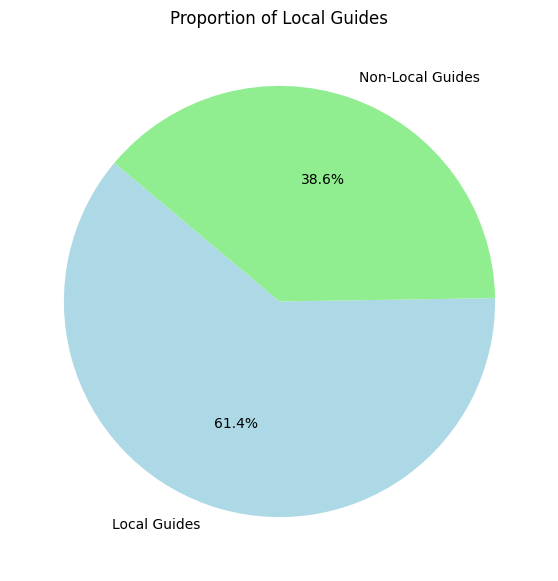

In [ ]:
local_guides_counts = combined_df['local_guide'].value_counts()
labels = 'Local Guides', 'Non-Local Guides'
colors = ['lightblue', 'lightgreen']
plt.figure(figsize=(7, 7))
plt.pie(local_guides_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Local Guides')
plt.show()

2. Number of reviews per store

<ipython-input-22-93e047cb2779>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Number of Reviews', y='Store name', data=reviews_count_df, palette="viridis")


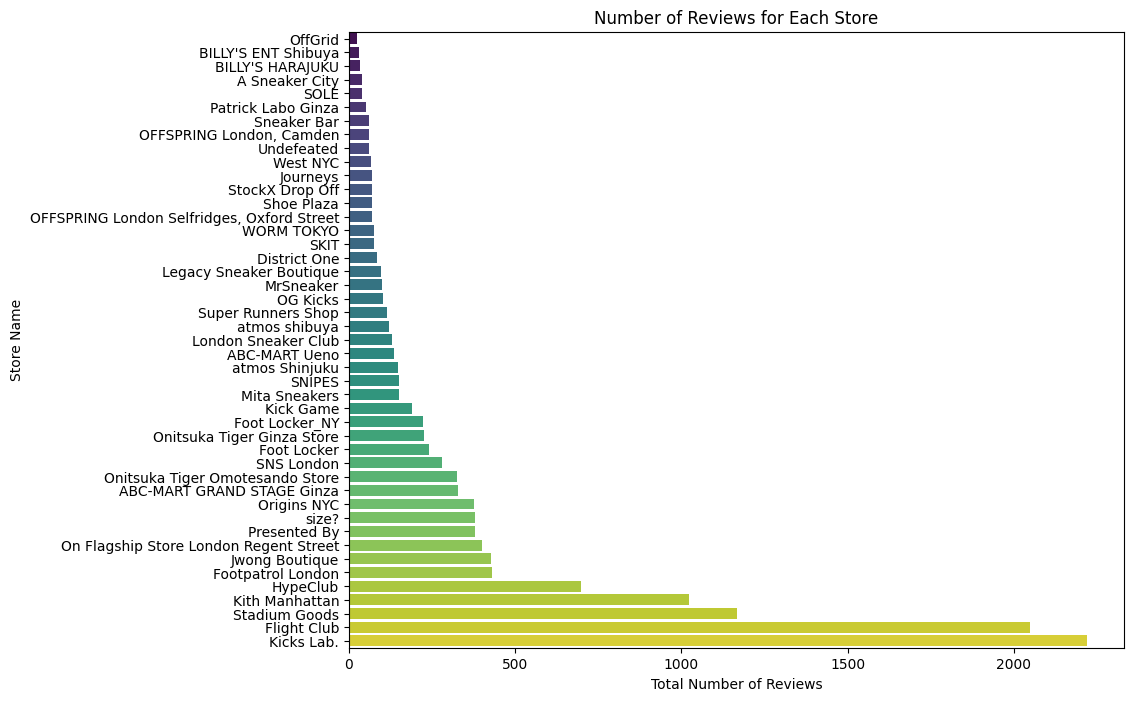

In [ ]:
reviews_count_per_store = combined_df['Store name'].value_counts()
reviews_count_df = reviews_count_per_store.reset_index()
reviews_count_df.columns = ['Store name', 'Number of Reviews']

#Sort the dataframe by the number of reviews
reviews_count_df = reviews_count_df.sort_values(by='Number of Reviews', ascending=True)

plt.figure(figsize=(10, 8))
sns.barplot(x='Number of Reviews', y='Store name', data=reviews_count_df, palette="viridis")
plt.title('Number of Reviews for Each Store')
plt.xlabel('Total Number of Reviews')
plt.ylabel('Store Name')
plt.show()

3. Word Cloud for all the reviews

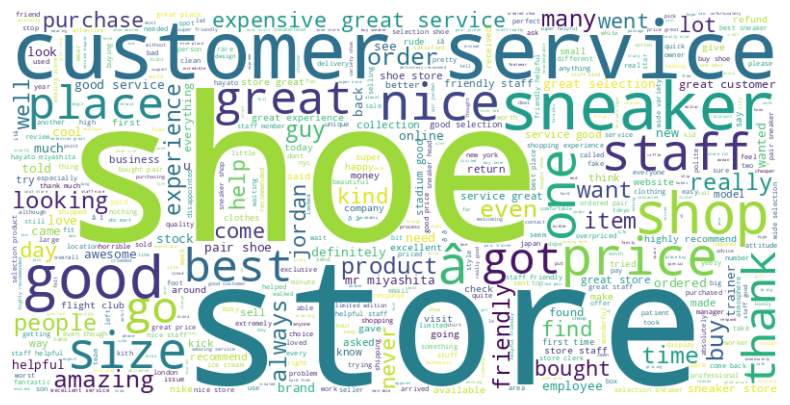

In [ ]:
text = " ".join(review for review in combined_df['Cleaned Review'].dropna() if review != "nan")
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue', width=800, height=400).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Calculate a naive sentiment socre using the internal pre-trained model contained in the TextBlob package
def analyze_sentiment(review):
    analysis = TextBlob(review)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity
combined_df['sentiment_polarity'], combined_df['sentiment_subjectivity'] = zip(*combined_df['Cleaned Review'].apply(analyze_sentiment))

In [ ]:
print(combined_df[['Cleaned Review', 'sentiment_polarity', 'sentiment_subjectivity']].head())

                                      Cleaned Review  sentiment_polarity  \
0  store small narrow making difficult get past s...           -0.228571   
1  william accommodating made visit easy happy he...            0.558333   
2  lovely experience certain worker ahmed helped ...            0.320000   
3  recent shopping experience store unfortunately...            0.043750   
4  hameema helpful air jordan 1 brother birthday ...            0.000000   

   sentiment_subjectivity  
0                0.564286  
1                0.708333  
2                0.491429  
3                0.556250  
4                0.000000  


4. Distribution of sentiment polarity score

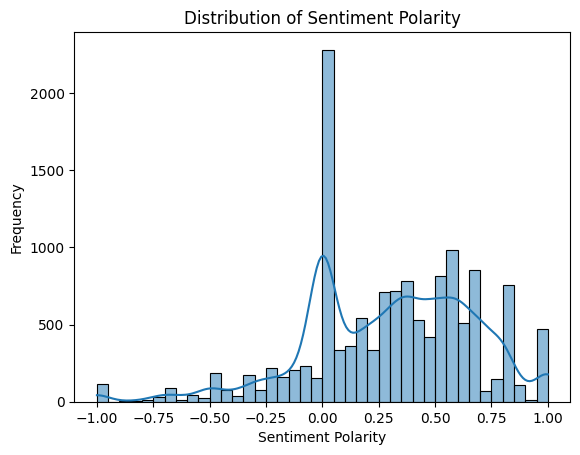

In [ ]:
sns.histplot(combined_df['sentiment_polarity'], kde=True)
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()